In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2
import glob
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set paths
IMAGE_DIR = r"E:\IRP_dataset_new\APTOS_images"
LABELS_PATH = r"E:\IRP_dataset_new\APTOS_labels.csv"

In [8]:
# 1. Load and explore the labels dataframe
df = pd.read_csv(LABELS_PATH)

# Display basic information
print(f"Labels dataframe shape: {df.shape}")
print("\nFirst 5 rows of the dataframe:")
display(df.head())

Labels dataframe shape: (3662, 2)

First 5 rows of the dataframe:


,id_code,diagnosis
0,000c1434d8d7,1
1,001639a390f0,1
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [9]:
print("\nColumn information:")
print(df.info())


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB
None


In [10]:
print("\nStatistical summary:")
display(df.describe())


Statistical summary:


,diagnosis
count,3662.000000
mean,0.507100
std,0.500018
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
# 2. Check for null values
print("\nChecking for null values:")
print(df.isnull().sum())


Checking for null values:
id_code      0
diagnosis    0
dtype: int64


In [12]:
# 3. Check for duplicates
print("\nChecking for duplicate id_code entries:")
duplicates = df[df.duplicated('id_code', keep=False)]
print(f"Number of duplicate id_code entries: {len(duplicates)}")
if len(duplicates) > 0:
    print("Duplicate entries:")
    display(duplicates)


Checking for duplicate id_code entries:
Number of duplicate id_code entries: 0


In [13]:
# 4. Class distribution
print("\nClass distribution:")
class_counts = df['diagnosis'].value_counts()
print(class_counts)
print(f"\nClass 0 percentage: {class_counts[0]/len(df)*100:.2f}%")
print(f"Class 1 percentage: {class_counts[1]/len(df)*100:.2f}%")


Class distribution:
diagnosis
1    1857
0    1805
Name: count, dtype: int64

Class 0 percentage: 49.29%
Class 1 percentage: 50.71%


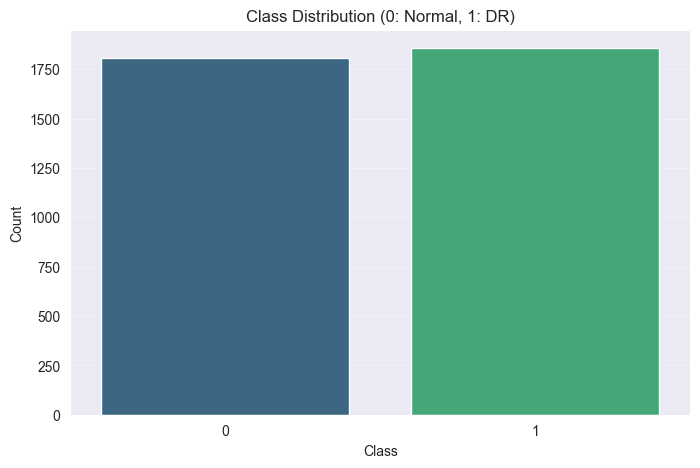

In [14]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Class Distribution (0: Normal, 1: DR)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [15]:
# 5. Check if all image files exist
print("\nChecking for missing image files...")
missing_images = []
for id_code in tqdm(df['id_code']):
    img_path = os.path.join(IMAGE_DIR, f"{id_code}.png")
    if not os.path.exists(img_path):
        missing_images.append(id_code)

print(f"Number of missing images: {len(missing_images)}")
if len(missing_images) > 0:
    print("First 10 missing images:", missing_images[:10])


Checking for missing image files...


  0%|          | 0/3662 [00:00<?, ?it/s]

Number of missing images: 9
First 10 missing images: ['2.3255E+11', '3.89552E+11', '4.41118E+11', '5.35683E+11', '5.49381E+11', '5.95447E+11', '7.21214E+11', '9.21433E+11', '9.46545E+11']


In [16]:
# 6. Check for corrupted images
print("\nChecking for corrupted images...")
corrupted_images = []
for id_code in tqdm(df['id_code']):
    img_path = os.path.join(IMAGE_DIR, f"{id_code}.png")
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path)
            img.verify()  # Verify image integrity
            img.close()
            
            # Also try to load with OpenCV
            cv_img = cv2.imread(img_path)
            if cv_img is None:
                corrupted_images.append(id_code)
        except Exception as e:
            corrupted_images.append(id_code)
            print(f"Error with image {id_code}: {str(e)}")

print(f"Number of corrupted images: {len(corrupted_images)}")
if len(corrupted_images) > 0:
    print("First 10 corrupted images:", corrupted_images[:10])


Checking for corrupted images...


  0%|          | 0/3662 [00:00<?, ?it/s]

Number of corrupted images: 0


In [17]:
# 7. Check image dimensions
print("\nAnalyzing image dimensions...")
dimensions = []
sizes = []

# Sample 100 random images or all if less than 100
sample_ids = np.random.choice(df['id_code'].values, 
                              size=min(100, len(df)), 
                              replace=False)

for id_code in tqdm(sample_ids):
    img_path = os.path.join(IMAGE_DIR, f"{id_code}.png")
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path)
            dimensions.append(img.size)
            sizes.append(os.path.getsize(img_path) / 1024)  # Size in KB
            img.close()
        except:
            pass

# Convert to dataframe for analysis
dim_df = pd.DataFrame(dimensions, columns=['width', 'height'])
dim_df['aspect_ratio'] = dim_df['width'] / dim_df['height']
dim_df['file_size_kb'] = sizes

print("\nImage dimensions summary:")
display(dim_df.describe())


Analyzing image dimensions...


  0%|          | 0/100 [00:00<?, ?it/s]


Image dimensions summary:


,width,height,aspect_ratio,file_size_kb
count,100.000000,100.000000,100.000000,100.000000
mean,2104.900000,1571.780000,1.303858,2281.004580
std,881.363527,527.948413,0.184616,1685.320217
min,819.000000,614.000000,1.000000,266.217773
25%,1050.000000,1050.000000,1.309119,1015.541260
50%,2416.000000,1736.000000,1.333333,1886.044922
75%,2588.000000,1958.000000,1.416207,2469.457520
max,4288.000000,2848.000000,1.505618,7185.666992


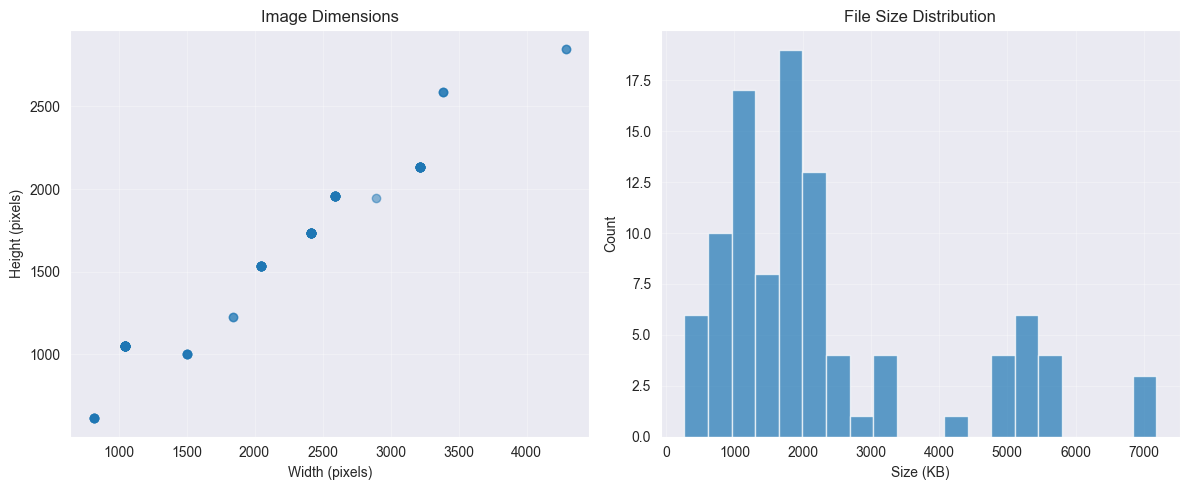

In [18]:
# Plot dimension distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(dim_df['width'], dim_df['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(dim_df['file_size_kb'], bins=20, alpha=0.7)
plt.title('File Size Distribution')
plt.xlabel('Size (KB)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Displaying sample images from each class:


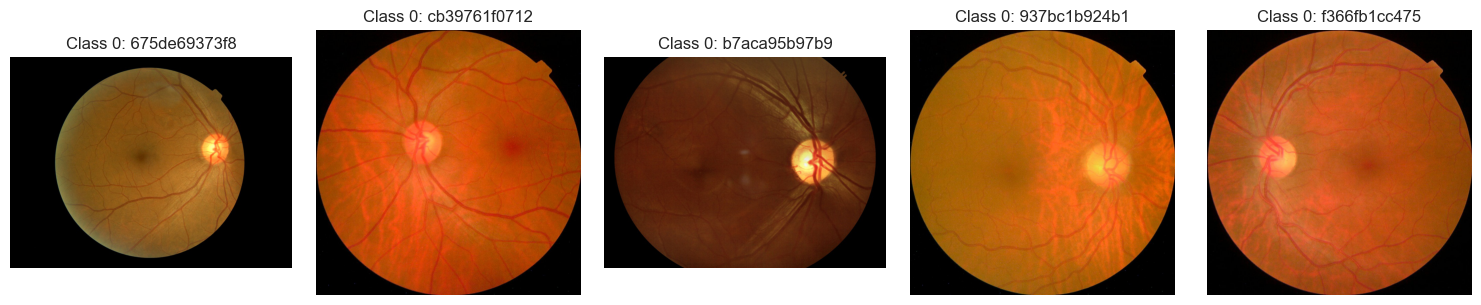

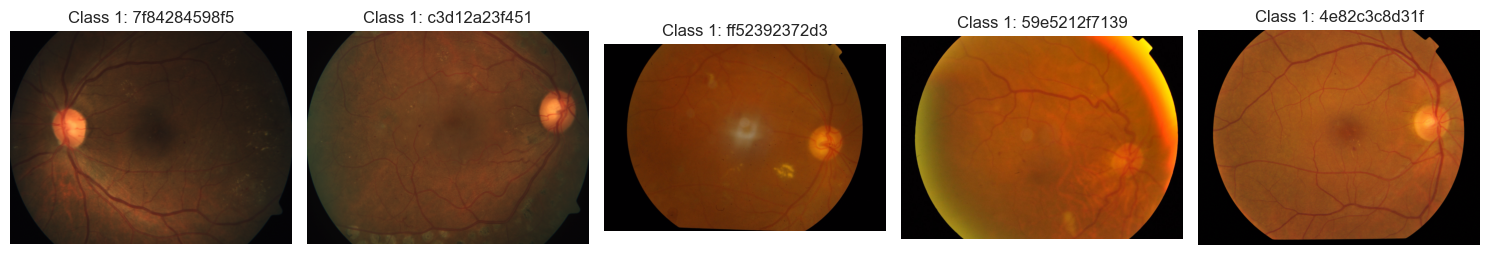

In [19]:
# 8. Visualize sample images from each class
print("\nDisplaying sample images from each class:")
def show_samples(class_val, num_samples=5):
    class_ids = df[df['diagnosis'] == class_val]['id_code'].values
    samples = np.random.choice(class_ids, size=min(num_samples, len(class_ids)), replace=False)
    
    plt.figure(figsize=(15, 3))
    for i, id_code in enumerate(samples):
        img_path = os.path.join(IMAGE_DIR, f"{id_code}.png")
        if os.path.exists(img_path):
            plt.subplot(1, num_samples, i+1)
            img = plt.imread(img_path)
            plt.imshow(img)
            plt.title(f"Class {class_val}: {id_code}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(0)  # Normal class
show_samples(1)  # DR class

In [20]:
# 9. Image quality assessment
print("\nPerforming basic image quality assessment...")
# We'll check brightness, contrast, and blurriness on a sample of images
quality_metrics = []

for id_code in tqdm(sample_ids):
    img_path = os.path.join(IMAGE_DIR, f"{id_code}.png")
    if os.path.exists(img_path):
        try:
            # Read image with OpenCV
            img = cv2.imread(img_path)
            if img is not None:
                # Convert to grayscale
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Calculate brightness (mean pixel value)
                brightness = np.mean(gray)
                
                # Calculate contrast (standard deviation of pixel values)
                contrast = np.std(gray)
                
                # Calculate blurriness (variance of Laplacian)
                laplacian = cv2.Laplacian(gray, cv2.CV_64F)
                blurriness = np.var(laplacian)
                
                # Get label
                label = df[df['id_code'] == id_code]['diagnosis'].values[0]
                
                quality_metrics.append({
                    'id_code': id_code,
                    'brightness': brightness,
                    'contrast': contrast,
                    'blurriness': blurriness,
                    'class': label
                })
        except Exception as e:
            print(f"Error analyzing image {id_code}: {str(e)}")

# Convert to dataframe
quality_df = pd.DataFrame(quality_metrics)

print("\nImage quality metrics summary:")
display(quality_df.describe())



Performing basic image quality assessment...


  0%|          | 0/100 [00:00<?, ?it/s]


Image quality metrics summary:


,brightness,contrast,blurriness,class
count,100.000000,100.000000,100.000000,100.000000
mean,68.919078,40.927311,22.398429,0.560000
std,19.524272,9.541647,17.803926,0.498888
min,19.536909,17.731466,2.702756,0.000000
25%,52.764589,33.980723,8.922491,0.000000
50%,71.952489,43.148431,14.585672,1.000000
75%,84.471355,46.891951,34.993195,1.000000
max,117.317904,67.415432,71.210463,1.000000


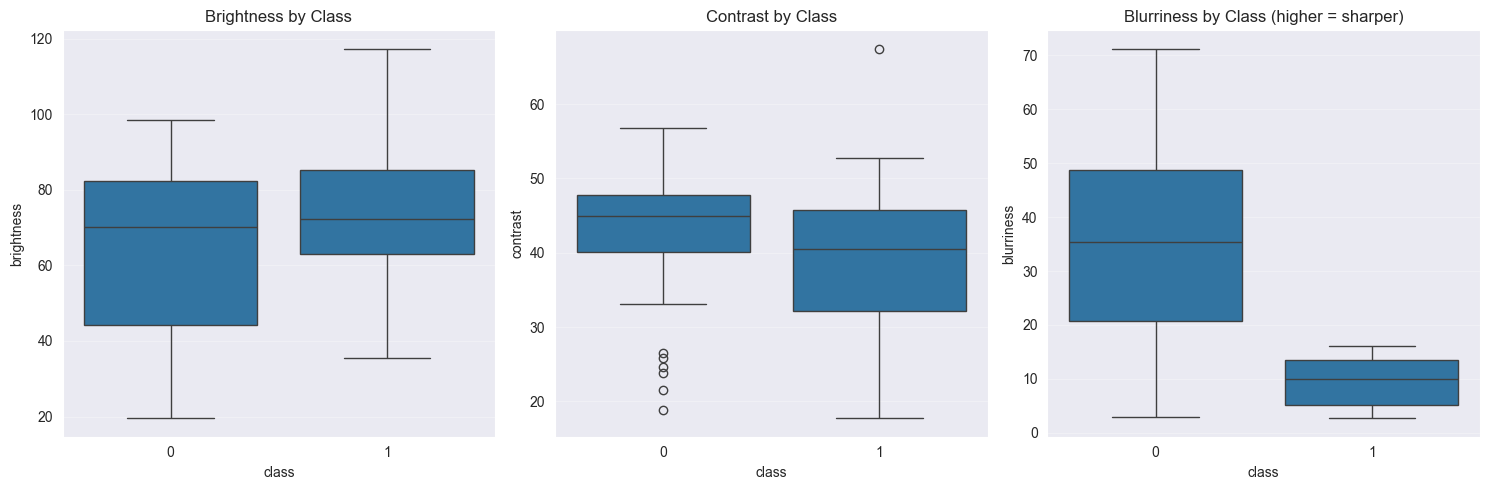

In [21]:
# Plot quality metrics by class
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='class', y='brightness', data=quality_df)
plt.title('Brightness by Class')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 2)
sns.boxplot(x='class', y='contrast', data=quality_df)
plt.title('Contrast by Class')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 3)
sns.boxplot(x='class', y='blurriness', data=quality_df, showfliers=False)
plt.title('Blurriness by Class (higher = sharper)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# 10. Summary
print("\n==== DATASET SUMMARY ====")
print(f"Total number of samples: {len(df)}")
print(f"Class distribution: Class 0 (Normal): {class_counts[0]} ({class_counts[0]/len(df)*100:.2f}%), "
      f"Class 1 (DR): {class_counts[1]} ({class_counts[1]/len(df)*100:.2f}%)")
print(f"Missing images: {len(missing_images)}")
print(f"Corrupted images: {len(corrupted_images)}")
print(f"Image dimensions variation: {len(set(dimensions))}")

if len(dim_df) > 0:
    most_common_dim = dim_df[['width', 'height']].value_counts().idxmax()
    print(f"Most common dimension: {most_common_dim}")

# Check if there are any issues that need attention
issues = []
if len(missing_images) > 0:
    issues.append(f"- {len(missing_images)} missing images")
if len(corrupted_images) > 0:
    issues.append(f"- {len(corrupted_images)} corrupted images")
if len(duplicates) > 0:
    issues.append(f"- {len(duplicates)} duplicate ID entries")
if abs(class_counts[0]/len(df) - 0.5) > 0.2:  # If class imbalance is severe
    issues.append(f"- Severe class imbalance: {class_counts[0]/len(df)*100:.1f}% vs {class_counts[1]/len(df)*100:.1f}%")

if issues:
    print("\nIssues requiring attention:")
    for issue in issues:
        print(issue)
else:
    print("\nNo major issues detected in the dataset")


==== DATASET SUMMARY ====
Total number of samples: 3662
Class distribution: Class 0 (Normal): 1805 (49.29%), Class 1 (DR): 1857 (50.71%)
Missing images: 9
Corrupted images: 0
Image dimensions variation: 11
Most common dimension: (1050, 1050)

Issues requiring attention:
- 9 missing images


In [25]:
# Code to remove missing images from the CSV and save a clean version

import pandas as pd
import os
from tqdm.notebook import tqdm

# Set paths
IMAGE_DIR = r"E:\IRP_dataset_new\APTOS_images"
LABELS_PATH = r"E:\IRP_dataset_new\APTOS_labels.csv"
OUTPUT_PATH = r"E:\IRP_dataset_new\APTOS_labels_cleaned.csv"  # Path for the cleaned CSV

print("Loading labels data...")
df = pd.read_csv(LABELS_PATH)
print(f"Original dataset size: {len(df)} entries")

# Get all image filenames from the directory
print("\nGetting all images from directory...")
all_image_files = os.listdir(IMAGE_DIR)
image_files = [f for f in all_image_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total image files found: {len(image_files)}")

# Extract just the id_codes from the filenames (remove file extensions)
image_ids = [os.path.splitext(img)[0] for img in image_files]
image_ids_set = set(image_ids)

# Create a new dataframe with only entries that have corresponding images
print("\nFiltering dataset to keep only entries with corresponding images...")
df_clean = df[df['id_code'].isin(image_ids_set)]

# Count removed entries
removed_count = len(df) - len(df_clean)
print(f"Removed {removed_count} entries without corresponding images")
print(f"Clean dataset size: {len(df_clean)} entries")

# Check class distribution in cleaned dataset
print("\nClass distribution in cleaned dataset:")
class_counts = df_clean['diagnosis'].value_counts()
print(class_counts)
print(f"Class 0 percentage: {class_counts[0]/len(df_clean)*100:.2f}%")
print(f"Class 1 percentage: {class_counts[1]/len(df_clean)*100:.2f}%")

# Save the cleaned dataset
print(f"\nSaving cleaned dataset to {OUTPUT_PATH}...")
df_clean.to_csv(OUTPUT_PATH, index=False)
print("Done!")

# Optional: Create a list of images that don't have entries in the CSV
orphaned_images = list(set(image_ids) - set(df['id_code']))
if orphaned_images:
    print(f"\nFound {len(orphaned_images)} images without corresponding entries in the CSV.")
    print("First 5 orphaned images:")
    for img_id in orphaned_images[:5]:
        print(f"- {img_id}")
    
    # Save the list of orphaned images to a text file
    orphaned_path = r"E:\IRP_dataset_new\orphaned_images.txt"
    print(f"Saving list of orphaned images to {orphaned_path}...")
    with open(orphaned_path, 'w') as f:
        for img_id in orphaned_images:
            f.write(f"{img_id}\n")
    print("Done!")

Loading labels data...
Original dataset size: 3662 entries

Getting all images from directory...
Total image files found: 3662

Filtering dataset to keep only entries with corresponding images...
Removed 9 entries without corresponding images
Clean dataset size: 3653 entries

Class distribution in cleaned dataset:
diagnosis
1    1853
0    1800
Name: count, dtype: int64
Class 0 percentage: 49.27%
Class 1 percentage: 50.73%

Saving cleaned dataset to E:\IRP_dataset_new\APTOS_labels_cleaned.csv...
Done!

Found 9 images without corresponding entries in the CSV.
First 5 orphaned images:
- 921433215353
- 549381330191
- 441117562359
- 595446774178
- 946545473380
Saving list of orphaned images to E:\IRP_dataset_new\orphaned_images.txt...
Done!


In [26]:
# Code to verify all entries in the CSV have corresponding images

import pandas as pd
import os
from tqdm.notebook import tqdm

# Set paths - you can use either your original or cleaned CSV file
CSV_PATH = r"E:\IRP_dataset_new\APTOS_labels_cleaned.csv"  # Use your cleaned CSV
IMAGE_DIR = r"E:\IRP_dataset_new\APTOS_images"

print(f"Loading CSV data from {CSV_PATH}...")
df = pd.read_csv(CSV_PATH)
print(f"Total entries in CSV: {len(df)}")

# Get all image filenames from the directory
print("\nScanning image directory...")
all_image_files = os.listdir(IMAGE_DIR)
image_files = [f for f in all_image_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total image files found: {len(image_files)}")

# Extract just the id_codes from the filenames (remove file extensions)
image_ids = [os.path.splitext(img)[0] for img in image_files]
image_ids_set = set(image_ids)

# Check if all CSV entries have matching images
print("\nVerifying that all CSV entries have matching images...")
missing_images = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    id_code = row['id_code']
    if id_code not in image_ids_set:
        missing_images.append(id_code)

# Display results
if missing_images:
    print(f"\n⚠️ Found {len(missing_images)} entries in CSV without matching images:")
    print("First 10 missing images:")
    for id_code in missing_images[:10]:
        print(f"- {id_code}")
else:
    print(f"\n✅ All {len(df)} entries in the CSV have matching images in the directory!")

# Optional: Verify specific examples with file paths
print("\nVerifying a few random examples with full file paths:")
sample_ids = df['id_code'].sample(min(5, len(df))).tolist()
for id_code in sample_ids:
    img_path = os.path.join(IMAGE_DIR, f"{id_code}.png")
    img_exists = os.path.exists(img_path)
    status = "✅ Found" if img_exists else "❌ Missing"
    print(f"{status}: {id_code} -> {img_path}")

# Summary statistics
print("\n==== VERIFICATION SUMMARY ====")
print(f"Total entries in CSV: {len(df)}")
print(f"Total image files found: {len(image_files)}")
print(f"CSV entries with missing images: {len(missing_images)}")
print(f"CSV entries with matching images: {len(df) - len(missing_images)}")

if len(df) > 0:
    match_percentage = (len(df) - len(missing_images)) / len(df) * 100
    print(f"Match percentage: {match_percentage:.2f}%")

# Final verification message
if missing_images:
    print("\n⚠️ Action required: There are still entries in your CSV without matching images!")
else:
    print("\n✅ Verification complete: Your dataset is fully synchronized!")

Loading CSV data from E:\IRP_dataset_new\APTOS_labels_cleaned.csv...
Total entries in CSV: 3653

Scanning image directory...
Total image files found: 3662

Verifying that all CSV entries have matching images...


  0%|          | 0/3653 [00:00<?, ?it/s]


✅ All 3653 entries in the CSV have matching images in the directory!

Verifying a few random examples with full file paths:
✅ Found: 702de9dcde32 -> E:\IRP_dataset_new\APTOS_images\702de9dcde32.png
✅ Found: 2cceb07ff706 -> E:\IRP_dataset_new\APTOS_images\2cceb07ff706.png
✅ Found: b5204c0decc7 -> E:\IRP_dataset_new\APTOS_images\b5204c0decc7.png
✅ Found: 150fc7127582 -> E:\IRP_dataset_new\APTOS_images\150fc7127582.png
✅ Found: 19545647508e -> E:\IRP_dataset_new\APTOS_images\19545647508e.png

==== VERIFICATION SUMMARY ====
Total entries in CSV: 3653
Total image files found: 3662
CSV entries with missing images: 0
CSV entries with matching images: 3653
Match percentage: 100.00%

✅ Verification complete: Your dataset is fully synchronized!


In [27]:
# Code to remove images without corresponding entries in the CSV file

import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm

# Set paths
CSV_PATH = r"E:\IRP_dataset_new\APTOS_labels_cleaned.csv"  # Use your cleaned CSV
IMAGE_DIR = r"E:\IRP_dataset_new\APTOS_images"
BACKUP_DIR = r"E:\IRP_dataset_new\APTOS_orphaned_images"  # Backup folder for removed images

# Create backup directory if it doesn't exist
if not os.path.exists(BACKUP_DIR):
    os.makedirs(BACKUP_DIR)
    print(f"Created backup directory: {BACKUP_DIR}")

# Load CSV data
print(f"Loading CSV data from {CSV_PATH}...")
df = pd.read_csv(CSV_PATH)
print(f"Total entries in CSV: {len(df)}")

# Get all valid id_codes from the CSV
csv_ids = set(df['id_code'])

# Get all image files from the directory
print("\nScanning image directory...")
all_image_files = os.listdir(IMAGE_DIR)
image_files = [f for f in all_image_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total image files found: {len(image_files)}")

# Find orphaned images (images without CSV entries)
orphaned_images = []
for img_file in image_files:
    id_code = os.path.splitext(img_file)[0]
    if id_code not in csv_ids:
        orphaned_images.append(img_file)

print(f"\nFound {len(orphaned_images)} orphaned images (without CSV entries)")

# Ask for confirmation before proceeding
if orphaned_images:
    print("\nFirst 5 orphaned images to be moved:")
    for img in orphaned_images[:5]:
        print(f"- {img}")
    
    # Since we're in a notebook environment, we'll proceed without interactive confirmation
    print(f"\nProceeding to move {len(orphaned_images)} orphaned images to backup folder...")
    
    # Move orphaned images to backup directory
    moved_count = 0
    failed_count = 0
    
    for img_file in tqdm(orphaned_images):
        src_path = os.path.join(IMAGE_DIR, img_file)
        dst_path = os.path.join(BACKUP_DIR, img_file)
        
        try:
            shutil.move(src_path, dst_path)
            moved_count += 1
        except Exception as e:
            print(f"Error moving {img_file}: {str(e)}")
            failed_count += 1
    
    print(f"\nMoved {moved_count} orphaned images to {BACKUP_DIR}")
    if failed_count > 0:
        print(f"Failed to move {failed_count} images")
else:
    print("\nNo orphaned images found. All images have corresponding CSV entries!")

# Final verification
print("\nVerifying image directory after cleanup...")
remaining_images = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Images remaining in directory: {len(remaining_images)}")
print(f"CSV entries: {len(df)}")

if len(remaining_images) == len(df):
    print("\n✅ Success! The number of images matches the number of CSV entries.")
else:
    print(f"\n⚠️ Warning: The number of images ({len(remaining_images)}) doesn't match CSV entries ({len(df)})")

Created backup directory: E:\IRP_dataset_new\APTOS_orphaned_images
Loading CSV data from E:\IRP_dataset_new\APTOS_labels_cleaned.csv...
Total entries in CSV: 3653

Scanning image directory...
Total image files found: 3662

Found 9 orphaned images (without CSV entries)

First 5 orphaned images to be moved:
- 232549883508.png
- 389552047476.png
- 441117562359.png
- 535682537302.png
- 549381330191.png

Proceeding to move 9 orphaned images to backup folder...


  0%|          | 0/9 [00:00<?, ?it/s]


Moved 9 orphaned images to E:\IRP_dataset_new\APTOS_orphaned_images

Verifying image directory after cleanup...
Images remaining in directory: 3653
CSV entries: 3653

✅ Success! The number of images matches the number of CSV entries.
